# Real vs Fake faces images Classifier

## Subject
Deepfakes are a type of technology in the Artificial Intelligence field that consists of generating realistic images, audio, and videos of persons using Machine Learning.
Although some of the generated content can be easily distinguishable from real materials, some of them prove to be difficult to spot as artificial content.

## Goal
This project aims to build an image classifier able to classify images of faces into two classes: real and fake (generated by artificial intelligence).

## Data
The dataset used for this project can be accessed at: https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k

In [1]:
import PIL
import PIL.Image as Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import os
import math

In [8]:
# Extracting the test and validation data from their respective folders
trainData = list()
validationData = list()
# imgsPath = '/kaggle/input/rvf10k/rvf10k'
imgsPath = '/kaggle/working/rvf10k_aligned'

for dataFolder in os.listdir(imgsPath):
    for dataLabel in os.listdir(imgsPath+'/'+dataFolder):
        for imName in os.listdir(imgsPath+'/'+dataFolder+'/'+dataLabel):
            imPath = imgsPath+'/'+dataFolder+'/'+dataLabel+'/'+imName
            if dataFolder == 'train':
                if dataLabel == 'fake':
                    trainData.append((Image.open(imPath), 'fake'))
                else:
                    trainData.append((Image.open(imPath), 'real'))
            elif dataFolder == 'valid':
                if dataLabel == 'fake':
                    validationData.append((Image.open(imPath), 'fake'))
                else:
                    validationData.append((Image.open(imPath), 'real'))

# Looking at data
Now that we have all the images that we'll use to train the model, let's take a look at some of the samples of each class (fake or real)

Num Real Samples: 3500
Num Fake samples: 3500


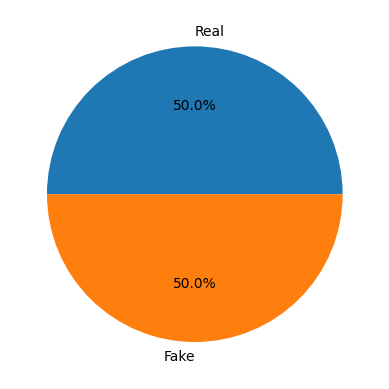

In [9]:
# Counting num. of samples of each class in training data
numReal = 0
numFake = 0


for sample in trainData:
    numReal += np.sum(sample[1] == 'real')
    numFake += np.sum(sample[1] == 'fake')

print(f'Num Real Samples: {numReal}\nNum Fake samples: {numFake}')
plt.pie([numReal, numFake], labels=['Real', 'Fake'], autopct='%1.1f%%')
plt.show()

In [10]:
# Checking shape of images

print(np.unique([sample[0].size for sample in trainData]))
print(np.unique([sample[0].size for sample in validationData]))

# All images have the shape (256, 256)

[128 256]
[128 256]


In [11]:
# Function to display N random sample images given its label (fake or real)
def showRandomImgs(data=trainData, imgs=5, label='fake', cols=5):
    rows = math.ceil(imgs / cols)
    images = list()
    cont = 0
    while True:
        if cont == imgs:
            break
        randImg = random.choice(data)
        if randImg[1] == label:  
            images.append(randImg[0])
            cont += 1

    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    indexImages = 0
    for r in range(rows):
        for c in range(cols):
            if indexImages == imgs:
                break
            if rows > 1:
                ax[r][c].imshow(images[indexImages])
                ax[r][c].axis('off')
                indexImages += 1
            else:
                ax[c].imshow(images[indexImages])
                ax[c].axis('off')
                indexImages += 1

In [ ]:
# Looking at 5 random training images labeled as "fake"
showRandomImgs(imgs=5, label='fake')

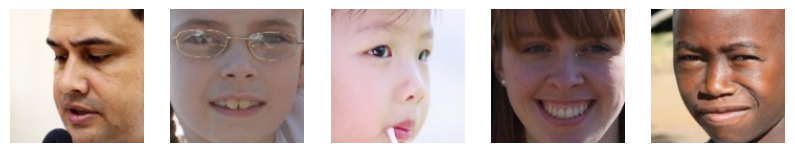

In [13]:
# Looking at 5 random training images labeled as "real"
showRandomImgs(imgs=5, label='real')

In [14]:
# Building Train Dataset Class
class TrainFaceDataset(Dataset):
    def __init__(self, trainData, transforms=None):
        self.trainData = trainData
        self.len = len(trainData)
        self.transforms = transforms
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image = self.trainData[index][0]
        label = 0 if self.trainData[index][1] == 'real' else 1
        
        if self.transforms:
            image = self.transforms(image)
        
        return (image, label)

In [15]:
# Building Validation Dataset Class
class ValidationFaceDataset(Dataset):
    def __init__(self, validationData, transforms=None):
        self.validationData = validationData
        self.len = len(validationData)
        self.transforms = transforms
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image = self.validationData[index][0]
        label = 0 if self.validationData[index][1] == 'real' else 1
        
        if self.transforms:
            image = self.transforms(image)
        
        return (image, label)

# Transforming images

Let's use some transformations on the data:
- Normalize both training and validation data
- Flip Horizontally the image (probability of 50%)

In [16]:
trainTransformsComposed = transforms.Compose([transforms.ToTensor(), 
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                              transforms.RandomHorizontalFlip(p=0.5)])

validationTransformsComposed = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainDataset = TrainFaceDataset(trainData, transforms=trainTransformsComposed)
validationDataset = ValidationFaceDataset(validationData, transforms=validationTransformsComposed)

# Building CNN

In [17]:
class CNN(nn.Module):
    def __init__(self, input_dim=3, out_1=32, out_2=64, out_3=128, out_4=256, out_5=512):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_dim, out_channels=out_1, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(out_1)
        self.conv2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm2d(out_2)
        self.conv3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, padding=2)
        self.bn3 = nn.BatchNorm2d(out_3)
        self.conv4 = nn.Conv2d(in_channels=out_3, out_channels=out_4, kernel_size=3, padding=2)
        self.bn4 = nn.BatchNorm2d(out_4)
        self.conv5 = nn.Conv2d(in_channels=out_4, out_channels=out_5, kernel_size=3, padding=2)
        self.bn5 = nn.BatchNorm2d(out_5)
        self.fc1 = nn.Linear(512 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 4096)
        self.fc5 = nn.Linear(4096, 2)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.maxPool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        
        return x

In [18]:
# Checking if GPU is avaible to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('GPU?', torch.cuda.is_available())

GPU? True


In [19]:
model = CNN()

In [20]:
model = model.to(device)

In [21]:
batch_size = 4
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validationDataset, batch_size=batch_size, shuffle=True)

# Defining Hyper parameters for training

In [22]:
learning_rate = 0.002
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 50

In [23]:
def trainModel(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    results = {'costs': list(), 'accuracy': list()}
    for epoch in range(epochs):
        cost = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            cost += loss.item()
            optimizer.step()
            
        cost = cost / len(train_loader)
        
        accuracy = validateModel(model, validation_loader)['accuracy']
        results['accuracy'].append(accuracy.cpu())
        results['costs'].append(cost)
        print(f'Epoch: {epoch+1}/{epochs}\nLoss: {cost}\nAccuracy: {accuracy * 100:.2f}%\n____________________')
        
    return results

In [24]:
def validateModel(model, validation_loader):
    model.eval()
    validation_results = {'accuracy': 0, 'pred_labels': list(), 'true_labels': list()}
    correct = 0
    with torch.no_grad():
        for x, y in validation_loader:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x.float())
            
            _, label = y_hat.max(1)
            validation_results['pred_labels'].extend(label.cpu().numpy())
            validation_results['true_labels'].extend(y.cpu().numpy())
            correct += (label == y).sum()
        
    validation_results['accuracy'] = correct / len(validationDataset)
    model.train()
    return validation_results

# Training model

In [25]:
training_results = trainModel(model, train_loader, criterion, optimizer, num_epochs)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x12800 and 41472x512)

# Analyzing training results

In [ ]:
import torch

# Визначаємо пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Шлях до збереженої моделі
model_path = "/kaggle/working/model.pth"

if os.path.exists(model_path):
    print("Знайдено збережену модель. Завантаження...")
    model = CNN().to(device)  # Переносимо модель на GPU або CPU
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Модель успішно завантажена.")
else:
    print("Збережена модель не знайдена. Тренування нової...")
    model = CNN().to(device)  # Переносимо модель на GPU або CPU
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Тренування моделі
    training_results = trainModel(model, train_loader, criterion, optimizer, num_epochs)

    # Збереження моделі
    torch.save(model.state_dict(), model_path)
    print(f"Модель збережено за шляхом: {model_path}")


In [ ]:
def plotCostAccuracy(costs, accuracy):
    fig, ax1 = plt.subplots()
    color = 'red'
    ax1.plot(costs, color=color)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost', color=color)
    
    ax2 = ax1.twinx()
    color = 'blue'
    ax2.plot(accuracy, color=color)
    ax2.set_ylabel('Accuracy', color=color)

In [ ]:
# Let's plot a graph containing the info about Cost and Accuracy of the model
plotCostAccuracy(training_results['costs'], training_results['accuracy'])

In [ ]:
def plotConfusionMatrix(model=model, validation_loader=validation_loader):
    validation_results = validateModel(model, validation_loader)
    pred_labels = validation_results['pred_labels']
    true_labels = validation_results['true_labels']      
    
    confusion_mtx = confusion_matrix(y_pred=pred_labels, y_true=true_labels)
    disp = ConfusionMatrixDisplay(confusion_mtx, display_labels=['Real', 'Fake'])
    disp.plot()

In [ ]:
def plotMissClassified(model=model, validation_dataset=validationDataset, num_examples=5):
    cont = 0
    for x, y in DataLoader(validation_dataset, batch_size=1, shuffle=True):
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        _, predLabel = y_hat.max(1)
        if (predLabel != y):
            cont += 1
            fig, ax = plt.subplots(figsize=(3, 3))
            ax.imshow(x.cpu().permute(2, 3, 1, 0).squeeze())
            plt.title(f'True Label: {"Fake" if y.cpu().item() == 1 else "Real"} | Predicted Label: {"Fake" if predLabel == 1 else "Real"}')
            plt.show()
        if cont == num_examples:
            break

In [ ]:
# Let's plot some examples of missclassifed images
plotMissClassified()

In [1]:
import os
import urllib.request
import bz2
import shutil

# Вказуємо шлях до папки, де потрібно зберегти файл
target_directory = "/kaggle/working"  # Заміни на свою папку, якщо потрібно
os.makedirs(target_directory, exist_ok=True)

# URL файлу
url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
compressed_path = os.path.join(target_directory, "shape_predictor_68_face_landmarks.dat.bz2")
extracted_path = os.path.join(target_directory, "shape_predictor_68_face_landmarks.dat")

# Завантаження стисненого файлу
print("Downloading shape predictor...")
urllib.request.urlretrieve(url, compressed_path)

# Розпаковка .bz2
print("Extracting...")
with bz2.BZ2File(compressed_path, "rb") as fr, open(extracted_path, "wb") as fw:
    shutil.copyfileobj(fr, fw)

print("Done! File saved as", extracted_path)


Extracting...
Done! File saved as /kaggle/working/shape_predictor_68_face_landmarks.dat


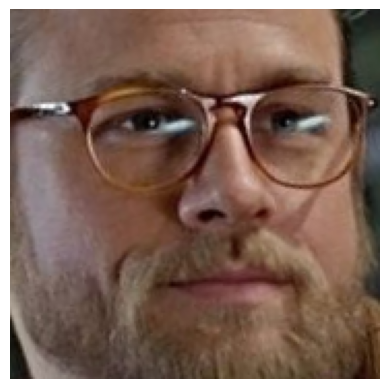

✅ Вирівняне обличчя збережено як aligned_face.jpg!


In [6]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Шлях до моделі
predictor_path = "/kaggle/working/shape_predictor_68_face_landmarks.dat"
image_path = "/kaggle/input/test-data/1.jpg"

# Завантажуємо детектор обличчя та модель ключових точок
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Завантажуємо зображення
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Виявлення облич на зображенні
faces = detector(gray)

if len(faces) == 0:
    print("❌ Обличчя не знайдено!")
else:
    for face in faces:
        # Визначення ключових точок обличчя
        landmarks = predictor(gray, face)

        # Отримуємо координати очей (ліва - 36, права - 45)
        left_eye = (landmarks.part(36).x, landmarks.part(36).y)
        right_eye = (landmarks.part(45).x, landmarks.part(45).y)

        # Обчислення кута нахилу
        delta_x = right_eye[0] - left_eye[0]
        delta_y = right_eye[1] - left_eye[1]
        angle = np.degrees(np.arctan2(delta_y, delta_x))

        # Центр обличчя для обертання
        center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

        # Обертання зображення
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

        # Обрізаємо обличчя після обертання
        face_aligned = rotated_image[face.top():face.bottom(), face.left():face.right()]

        # Відображаємо вирівняне обличчя
        plt.imshow(cv2.cvtColor(face_aligned, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Зберігаємо результат
        cv2.imwrite("/kaggle/working/aligned_face.jpg", face_aligned)
        print("✅ Вирівняне обличчя збережено як aligned_face.jpg!")


In [2]:
import os
import cv2
import dlib
import shutil
from tqdm import tqdm
from PIL import Image

# Вхідний та вихідний шляхи
input_dir = "/kaggle/input/rvf10k/rvf10k"
output_dir = "/kaggle/working/rvf10k_aligned"

# Завантажуємо детектор обличчя та модель для ключових точок
predictor_path = "/kaggle/working/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Функція для вирівнювання обличчя
def align_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        return None  # Якщо обличчя не знайдено, повертаємо None

    for face in faces:
        landmarks = predictor(gray, face)
        left_eye = (landmarks.part(36).x, landmarks.part(36).y)
        right_eye = (landmarks.part(45).x, landmarks.part(45).y)

        # Обчислення кута нахилу
        delta_x = right_eye[0] - left_eye[0]
        delta_y = right_eye[1] - left_eye[1]
        angle = cv2.fastAtan2(delta_y, delta_x)

        # Центр обличчя для обертання
        center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, float(angle), 1)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

        # Обрізаємо обличчя
        face_aligned = rotated_image[face.top():face.bottom(), face.left():face.right()]
        return cv2.resize(face_aligned, (128, 128))  # Масштабуємо до 128x128

# Проходимося по всьому датасету
for dataFolder in ["train", "valid"]:
    for dataLabel in ["fake", "real"]:
        input_path = os.path.join(input_dir, dataFolder, dataLabel)
        output_path = os.path.join(output_dir, dataFolder, dataLabel)

        os.makedirs(output_path, exist_ok=True)  # Створюємо вихідні папки

        for imName in tqdm(os.listdir(input_path), desc=f"Processing {dataFolder}/{dataLabel}"):
            imPath = os.path.join(input_path, imName)
            image = cv2.imread(imPath)

            if image is None:
                continue  # Пропускаємо, якщо зображення не відкривається

            aligned_face = align_face(image)

            if aligned_face is not None:
                # Зберігаємо вирівняне обличчя у новий датасет
                save_path = os.path.join(output_path, imName)
                cv2.imwrite(save_path, aligned_face)
            else:
                # Якщо обличчя не знайдено, копіюємо оригінальне зображення
                shutil.copy(imPath, output_path)

print("✅ Всі обличчя вирівняні та збережені!")


Processing valid/real: 100%|██████████| 1500/1500 [00:28<00:00, 52.22it/s]

✅ Всі обличчя вирівняні та збережені!


First image: /kaggle/working/rvf10k_aligned/train/real/00003.jpg


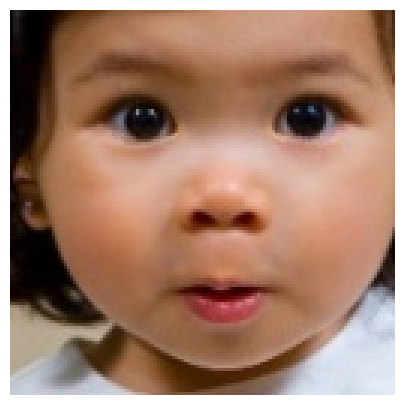

In [10]:
import os
import matplotlib.pyplot as plt
import cv2


if image_files:  # Перевіряємо, чи є файли
    print("First image:", first_image_path)
else:
    print("No images found in the directory.")
if image_files:
    image = cv2.imread(first_image_path)  # Завантажуємо зображення
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертуємо в RGB

    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


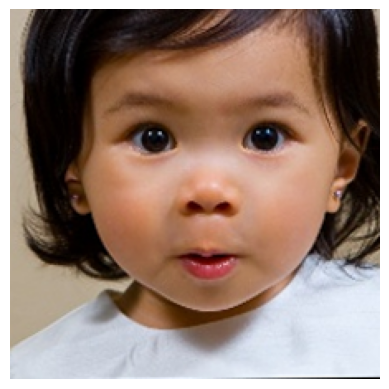

✅ Вирівняне обличчя збережено як /kaggle/working/aligned_face.jpg!


In [11]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Шлях до моделі
predictor_path = "/kaggle/working/shape_predictor_68_face_landmarks.dat"
image_path = "/kaggle/input/test-data/1.jpg"

# Завантажуємо детектор обличчя та модель ключових точок
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)


image_dir = "/kaggle/input/rvf10k/rvf10k/train/real"
image_files = sorted(os.listdir(image_dir))  # Отримуємо список файлів
first_image_path = os.path.join(image_dir, image_files[1])
image_path = first_image_path

# Завантажуємо зображення
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Виявлення облич на зображенні
faces = detector(gray)

if len(faces) == 0:
    print("❌ Обличчя не знайдено!")
else:
    for face in faces:
        # Визначення ключових точок обличчя
        landmarks = predictor(gray, face)

        # Отримуємо координати очей (ліва - 36, права - 45)
        left_eye = np.array([landmarks.part(36).x, landmarks.part(36).y])
        right_eye = np.array([landmarks.part(45).x, landmarks.part(45).y])

        # Обчислення кута нахилу
        delta_x = right_eye[0] - left_eye[0]
        delta_y = right_eye[1] - left_eye[1]
        angle = np.degrees(np.arctan2(delta_y, delta_x))

        # Центр обличчя для обертання
        # Центр між очима (переконані, що передаємо int)
        eyes_center = (int((left_eye[0] + right_eye[0]) // 2), int((left_eye[1] + right_eye[1]) // 2))
        
        # Отримання матриці обертання
        rotation_matrix = cv2.getRotationMatrix2D(eyes_center, angle, 1)


        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

        # Вирахування нових координат обличчя після обертання
        x, y, w, h = face.left(), face.top(), face.width(), face.height()

        # Додаємо паддінг, щоб уникнути обрізання, якщо обличчя на краю кадру
        padding = int(0.2 * h)  # Додаємо 20% від висоти обличчя
        x, y = max(0, x - padding), max(0, y - padding)
        w, h = min(image.shape[1] - x, w + 2 * padding), min(image.shape[0] - y, h + 2 * padding)

        # Обрізаємо обличчя після обертання
        face_aligned = rotated_image[y:y + h, x:x + w]

        # Масштабуємо (опціонально, якщо потрібно привести до єдиного розміру, напр. 224x224)
        target_size = (224, 224)  # Можна змінити або прибрати, якщо не потрібно
        face_aligned = cv2.resize(face_aligned, target_size, interpolation=cv2.INTER_CUBIC)

        # Відображаємо вирівняне обличчя
        plt.imshow(cv2.cvtColor(face_aligned, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Зберігаємо результат
        output_path = "/kaggle/working/aligned_face.jpg"
        cv2.imwrite(output_path, face_aligned, [cv2.IMWRITE_JPEG_QUALITY, 95])
        print(f"✅ Вирівняне обличчя збережено як {output_path}!")


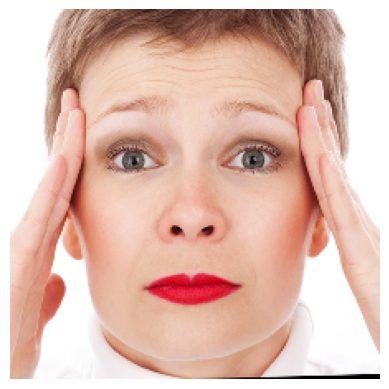

✅ Вирівняне обличчя збережено як /kaggle/working/aligned_face.jpg!


In [15]:
import os
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

def align_face(image_path, predictor_path, output_path=None, target_size=(224, 224)):
    """
    Вирівнює обличчя на зображенні, мінімізуючи втрату якості.

    Args:
        image_path (str): Шлях до зображення.
        predictor_path (str): Шлях до моделі dlib з ключовими точками.
        output_path (str, optional): Шлях для збереження результату. Якщо None, не зберігається.
        target_size (tuple, optional): Бажаний розмір вихідного зображення (за замовчуванням 224x224).

    Returns:
        np.array: Вирівняне зображення обличчя або None, якщо обличчя не знайдено.
    """
    # Завантажуємо детектор обличчя та модель ключових точок
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    # Завантажуємо зображення
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Неможливо завантажити зображення: {image_path}")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Виявлення облич на зображенні
    faces = detector(gray)
    if len(faces) == 0:
        print("❌ Обличчя не знайдено!")
        return None

    for face in faces:
        # Визначення ключових точок обличчя
        landmarks = predictor(gray, face)

        # Отримуємо координати очей (ліва - 36, права - 45)
        left_eye = np.array([landmarks.part(36).x, landmarks.part(36).y])
        right_eye = np.array([landmarks.part(45).x, landmarks.part(45).y])

        # Обчислення кута нахилу
        delta_x = right_eye[0] - left_eye[0]
        delta_y = right_eye[1] - left_eye[1]
        angle = np.degrees(np.arctan2(delta_y, delta_x))

        # Центр між очима
        eyes_center = (int((left_eye[0] + right_eye[0]) // 2), int((left_eye[1] + right_eye[1]) // 2))

        # Отримання матриці обертання (бікубічна інтерполяція для високої якості)
        rotation_matrix = cv2.getRotationMatrix2D(eyes_center, angle, 1)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

        # Вирахування нових координат обличчя після обертання
        x, y, w, h = face.left(), face.top(), face.width(), face.height()

        # Додаємо паддінг (20% від висоти обличчя)
        padding = int(0.2 * h)
        x, y = max(0, x - padding), max(0, y - padding)
        w, h = min(image.shape[1] - x, w + 2 * padding), min(image.shape[0] - y, h + 2 * padding)

        # Обрізаємо обличчя
        face_aligned = rotated_image[y:y + h, x:x + w]

        # Масштабуємо до потрібного розміру (якщо задано)
        if target_size:
            face_aligned = cv2.resize(face_aligned, target_size, interpolation=cv2.INTER_CUBIC)

        # Відображаємо зображення
        plt.imshow(cv2.cvtColor(face_aligned, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Зберігаємо результат, якщо вказано шлях
        if output_path:
            cv2.imwrite(output_path, face_aligned, [cv2.IMWRITE_JPEG_QUALITY, 95])
            print(f"✅ Вирівняне обличчя збережено як {output_path}!")

        return face_aligned  # Повертаємо зображення у вигляді масиву NumPy

    return None  # Якщо обличчя не знайдено


# Використання:
predictor_path = "/kaggle/working/shape_predictor_68_face_landmarks.dat"
image_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_real/real_00002.jpg"
output_path = "/kaggle/working/aligned_face.jpg"

aligned_face = align_face(image_path, predictor_path, output_path)


In [2]:
!pip install -q colab_ssh --upgrade



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\malyn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
from colab_ssh import launch_ssh
launch_ssh("malynovskyi", "6c8ae1685709c1843522e3bef4111668")

ModuleNotFoundError: No module named 'apt'